# How to create branches for parallel node execution

LangGraph4j lets you run nodes in parallel to speed up your total graph execution.

Currently there are some limitations on parallel execution:

 
* Only the **Fork-Join** model is supported
 
  > ```
  >        ┌─┐       
  >        │A│       
  >        └─┘       
  >         |        
  >   ┌-----------┐  
  >   |     |     |  
  > ┌──┐  ┌──┐  ┌──┐ 
  > │A1│  │A2│  │A3│ 
  > └──┘  └──┘  └──┘ 
  >   |     |     |  
  >   └-----------┘  
  >         |        
  >        ┌─┐       
  >        │B│       
  >        └─┘       
  >   ```
* No **Conditional Edges** are allowed
  
Below are some examples showing how to add create branching dataflows that work for you.


In [1]:
var userHomeDir = System.getProperty("user.home");
var localRespoUrl = "file://" + userHomeDir + "/.m2/repository/";
var langchain4jVersion = "0.36.2";
var langgraph4jVersion = "1.3-SNAPSHOT";

In [2]:
%%bash 
rm -rf \{userHomeDir}/Library/Jupyter/kernels/rapaio-jupyter-kernel/mima_cache/org/bsc/langgraph4j

In [3]:
%dependency /add-repo local \{localRespoUrl} release|never snapshot|always
// %dependency /list-repos
%dependency /add org.slf4j:slf4j-jdk14:2.0.9
%dependency /add org.bsc.langgraph4j:langgraph4j-core:\{langgraph4jVersion}
%dependency /add org.bsc.langgraph4j:langgraph4j-langchain4j:\{langgraph4jVersion}
%dependency /add dev.langchain4j:langchain4j:\{langchain4jVersion}
%dependency /add dev.langchain4j:langchain4j-open-ai:\{langchain4jVersion}
%dependency /add net.sourceforge.plantuml:plantuml-mit:1.2024.8

%dependency /resolve

Repository local url: file:///Users/bsorrentino/.m2/repository/ added.
Adding dependency org.slf4j:slf4j-jdk14:2.0.9
Adding dependency org.bsc.langgraph4j:langgraph4j-core:1.3-SNAPSHOT
Adding dependency org.bsc.langgraph4j:langgraph4j-langchain4j:1.3-SNAPSHOT
Adding dependency dev.langchain4j:langchain4j:0.36.2
Adding dependency dev.langchain4j:langchain4j-open-ai:0.36.2
Adding dependency net.sourceforge.plantuml:plantuml-mit:1.2024.8
Solving dependencies
Resolved artifacts count: 27
Add to classpath: /Users/bsorrentino/Library/Jupyter/kernels/rapaio-jupyter-kernel/mima_cache/org/slf4j/slf4j-jdk14/2.0.9/slf4j-jdk14-2.0.9.jar
Add to classpath: /Users/bsorrentino/Library/Jupyter/kernels/rapaio-jupyter-kernel/mima_cache/org/slf4j/slf4j-api/2.0.9/slf4j-api-2.0.9.jar
Add to classpath: /Users/bsorrentino/Library/Jupyter/kernels/rapaio-jupyter-kernel/mima_cache/org/bsc/langgraph4j/langgraph4j-core/1.3-SNAPSHOT/langgraph4j-core-1.3-SNAPSHOT.jar
Add to classpath: /Users/bsorrentino/Library/Jupy

## Define Graph with parallel branch

In [ ]:
import org.bsc.langgraph4j.prebuilt.MessagesStateGraph;
import org.bsc.langgraph4j.prebuilt.MessagesState;
import org.bsc.langgraph4j.action.AsyncNodeAction;
import static org.bsc.langgraph4j.action.AsyncNodeAction.node_async;
import static org.bsc.langgraph4j.StateGraph.END;
import static org.bsc.langgraph4j.StateGraph.START;

AsyncNodeAction<MessagesState<String>> makeNode( String message ) {
    return node_async(state -> Map.of( "messages", message ) );
}

var childStep1 = makeNode( "A") ;

var childStep2 = makeNode( "step2") ;

var childStep3 = makeNode( "step3") ;


var workflow = new MessagesStateGraph<String>()
                .addNode("A", makeNode("A"))
                .addNode("A1", makeNode("A1"))
                .addNode("A2", makeNode("A2"))
                .addNode("A3", makeNode("A3"))
                .addNode("B", makeNode("B"))
                .addNode("C", makeNode("C"))
                .addEdge("A", "A1")
                .addEdge("A", "A2")
                .addEdge("A", "A3")
                .addEdge("A1", "B")
                .addEdge("A2", "B")
                .addEdge("A3", "B")
                .addEdge("B", "C")
                .addEdge(START, "A")
                .addEdge("C", END)                   
                .compile();


## Print graph representation

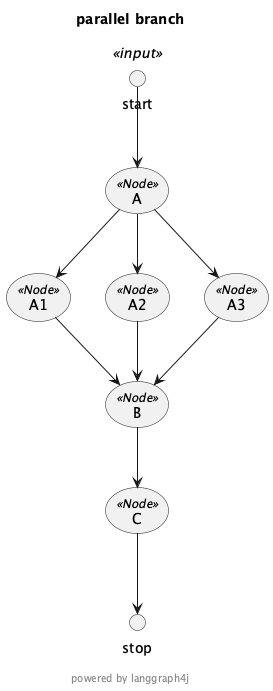

a38a7ffc-716e-4833-baed-788a0e2ac8ea

In [14]:
import org.bsc.langgraph4j.GraphRepresentation;
import net.sourceforge.plantuml.SourceStringReader;
import net.sourceforge.plantuml.FileFormatOption;
import net.sourceforge.plantuml.FileFormat;

java.awt.Image plantUML2PNG( String code ) throws IOException { 
    var reader = new SourceStringReader(code);

    try(var imageOutStream = new java.io.ByteArrayOutputStream()) {

        var description = reader.outputImage( imageOutStream, 0, new FileFormatOption(FileFormat.PNG));

        var imageInStream = new java.io.ByteArrayInputStream(  imageOutStream.toByteArray() );

        return javax.imageio.ImageIO.read( imageInStream );

    }
}


var representation = workflow.getGraph( GraphRepresentation.Type.PLANTUML, "parallel branch",false );

display( plantUML2PNG( representation.getContent() ) )

In [15]:
for( var step : workflow.stream( Map.of() ) ) {
    System.out.println( step );
}

NodeOutput{node=__START__, state={messages=[]}}
NodeOutput{node=A, state={messages=[A]}}
NodeOutput{node=__PARALLEL__(A), state={messages=[A, A1, A2, A3]}}
NodeOutput{node=B, state={messages=[A, A1, A2, A3, B]}}
NodeOutput{node=C, state={messages=[A, A1, A2, A3, B, C]}}
NodeOutput{node=__END__, state={messages=[A, A1, A2, A3, B, C]}}
